# MNIST with custom framework

In [1]:
from centigrad.nn import Module
from centigrad.layers import Linear, ReLU, LogSoftmax
from centigrad.losses import NLLLoss
from centigrad.optim import SGD
from utils.plot_histograms import gradient_distribution
import numpy as np
import matplotlib.pyplot as plt

## Load MNIST dataset

In [2]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

## Define the model

In [4]:
class NN(Module):
    def __init__(self):
        self.l1 = Linear(784, 32, bias=False)
        self.a1 = ReLU()
        self.l2 = Linear(32, 10, bias=False)
        self.a2 = LogSoftmax()
    def forward(self, inputs: np.ndarray):
        out = self.l1(inputs)
        out = self.a1(out)
        out = self.l2(out)
        out = self.a2(out)
        return out
    def parameters(self):
        params = []
        params.extend(self.l1.parameters())
        params.extend(self.l2.parameters())
        return params

In [5]:
model = NN()
loss_function = NLLLoss()
optim = SGD(model.parameters(), lr=0.001, momentum=0.0)
batch_size = 64
losses, accuracies = [], []

## Training

In [6]:
for k in range(10):
    # create batch
    samples = np.random.randint(0, x_train.shape[0], size=batch_size)
    xs = x_train[samples]
    ys = y_train[samples]
    # forward
    out = model(xs)
    loss = loss_function(out, ys)
    losses.append(loss.data)
    accuracy = np.mean(np.argmax(out, axis=1) == ys)
    accuracies.append(accuracy)
    # backward
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 30.751394683431297, accuracy 10.9375%
step 1 loss 12.945885922318862, accuracy 21.875%
step 2 loss 14.00285231125064, accuracy 12.5%
step 3 loss 10.49785854224218, accuracy 20.3125%
step 4 loss 3.336450234108179, accuracy 21.875%
step 5 loss 2.3332769991847875, accuracy 26.5625%
step 6 loss 2.0399176657439653, accuracy 39.0625%
step 7 loss 2.582385901997189, accuracy 15.625%
step 8 loss 2.0904887173721134, accuracy 23.4375%
step 9 loss 2.011156667581811, accuracy 25.0%


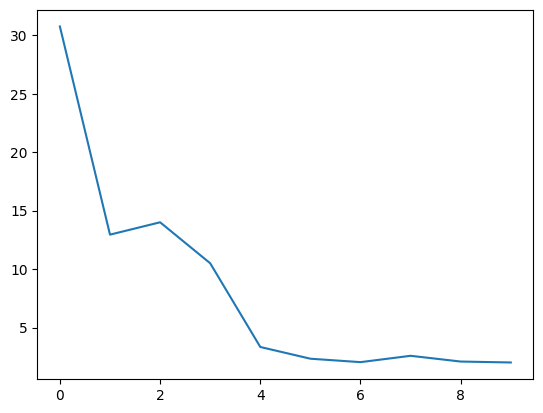

In [7]:
plt.plot(losses)

layer 1 (ReLU): mean +0.000004, std 1.339595e-03


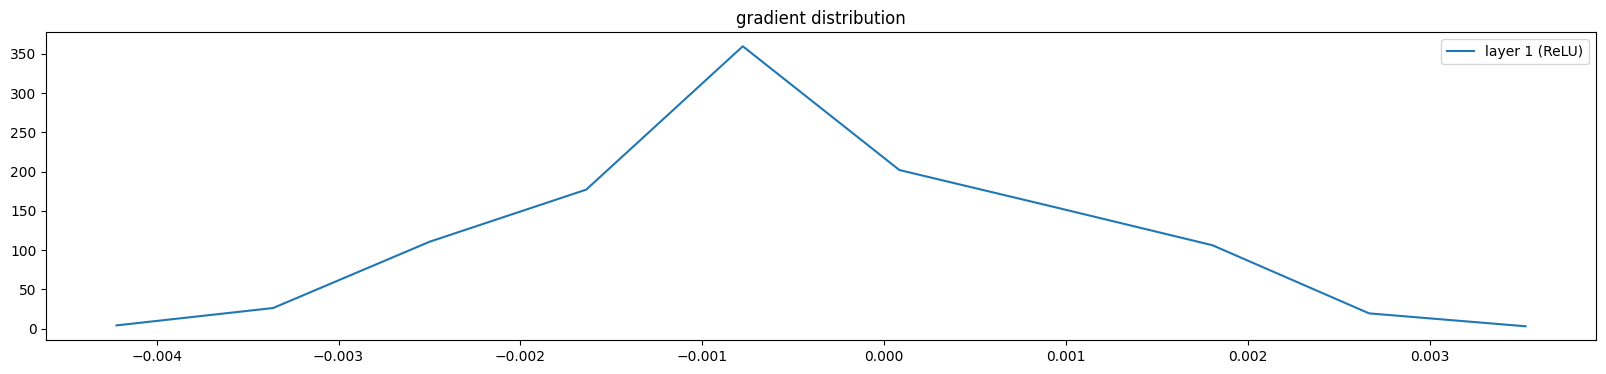

In [8]:
layers = [model.l1, model.a1, model.l2, model.a2]
gradient_distribution(layers, ReLU)